In [16]:
from bertopic import BERTopic
import statistics
import numpy as np
import json
from umap import UMAP
from hdbscan import HDBSCAN

'''
PDFs parsing:
Output format: a dictionary of dictionaries
The name of each document is used for the keys of the dictionary
Then, the value associated to that key is another dictionary, whose 
keys are the names of the sections and theirs values, the paragraphs
'''

# First we import the files
our_flyers_path = 'flyers_wo_outliers.json'

with open(our_flyers_path, 'r') as file:
    json_file = json.load(file)

# A section
#a = json_file["(Langdurig) gebroken vliezen"]['Check uw dossier op MijnZGT']

# The list of sections to analyze is the list of values of each value of the original dictionary (json file)
'''sections_dict = {} # The dictionary is to avoid repeated elements
saw_sections = []
counter = -1
for document in json_file.values(): 
    counter += 1
    for section in document.values(): 
        if section not in saw_sections:
            sections_dict[section] = counter
            saw_sections.append(section)'''
            
sections_list = []
saw_sections = []
counter = -1
for document in json_file.values(): 
    counter += 1
    for section in document.values(): 
        if section not in saw_sections:
            sections_list.append(section)
            
files_names_list = []
extended_files_names_list = []
sections_headers_list = []
for file_name in json_file.keys():
    files_names_list.append(file_name)
    aux_list = [file_name]*len(document.keys())
    extended_files_names_list.extend(aux_list)
    document = json_file[file_name]
    for header in document.keys():
        sections_headers_list.append(header)
'''
SOME OF THE SECTIONS ARE REPEATED, SO THERE'S LITTLE POINT ON KEEPING THEM
'''
#sections = list(sections_dict.keys())
#document_id_list = list(sections_dict.values())

# We put together the sections with their headers
section_headers_dict = {}
file_names_dict = {}
sections_list_ = []
for index,section in enumerate(sections_list): 
    if section not in list(file_names_dict.keys()):
        sections_list_.append(section)
    section_headers_dict[section] = sections_headers_list[index] 
    file_names_dict[section] = extended_files_names_list[index]
# Repeated sections we are only counting them once and putting them the header of the last document... 
# Hopefully, these headers would be the same for the repeated sections

print("Quantity of sections:", len(sections_list_))

Quantity of sections: 11292


In [25]:
# Apply BERTopic

from bertopic.backend import BaseEmbedder
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stopwords = stopwords.words('dutch')

class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.encode(documents, show_progress_bar=verbose)
        return embeddings 
    
# Add removing of stop words in CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords)

# Create custom backend
embedding_model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
custom_embedder = CustomEmbedder(embedding_model=embedding_model)

n_components = 35
min_cluster_size = 45

umap_model = UMAP(n_neighbors=15, n_components=n_components, min_dist=0.0, metric='cosine')
topic_model = BERTopic(embedding_model=custom_embedder, vectorizer_model=vectorizer_model, calculate_probabilities=True, verbose=True,
                       min_topic_size=min_cluster_size, umap_model=umap_model)
topics, probs = topic_model.fit_transform(sections_list_)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-01-17 12:58:31,299 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/353 [00:00<?, ?it/s]

2024-01-17 12:59:03,166 - BERTopic - Embedding - Completed ✓
2024-01-17 12:59:03,168 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-17 12:59:12,180 - BERTopic - Dimensionality - Completed ✓
2024-01-17 12:59:12,183 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-17 12:59:15,361 - BERTopic - Cluster - Completed ✓
2024-01-17 12:59:15,367 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-17 12:59:17,604 - BERTopic - Representation - Completed ✓


In [26]:
# Create the embeddings from the outside (need them to evaluate clusters without outliers)
from sklearn.metrics.pairwise import cosine_similarity

# Definir una función de distancia angular basada en la similitud del coseno
def angular_distance(X, Y=None):
    if Y is None:
        Y = X
    cosine_sim = cosine_similarity(X, Y)
    return 1 - cosine_sim


print("Creating embeddings manually...")

manual_embeddings = custom_embedder.embed(sections_list_, verbose=True)
umap_model = UMAP(n_neighbors=15, n_components=n_components, min_dist=0.0, metric='cosine')
reduced_embeddings = umap_model.fit_transform(manual_embeddings)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean", cluster_selection_method='eom', prediction_data=True)
labels = hdbscan_model.fit_predict(reduced_embeddings)
number_of_clusters = len(set(labels))

list_of_centroids = []
for label in labels:
    if label != -1: 
        centroid = hdbscan_model.weighted_cluster_centroid(label)
    else: 
        centroid = np.zeros(n_components)
    list_of_centroids.append(centroid)
    
print(number_of_clusters)

Creating embeddings manually...


Batches:   0%|          | 0/353 [00:00<?, ?it/s]

4


In [27]:
import pandas as pd
# CREATE BOGDAN'S DATAFRAME
list_of_representations = []
for key,value in topic_model.topic_representations_.items():
    topic_words = []
    for tuple_ in value: 
        topic_words.append(tuple_[0])
    list_of_representations.append(topic_words)

# For topic representations and embeddings we only have ~200 of them, so we have to expand them and put one for each sample
expanded_topic_words_list = []
expanded_centroid_list = []
for topic_id in topic_model.topics_: 
    expanded_topic_words_list.append(list_of_representations[topic_id+1])
    expanded_centroid_list.append(topic_model.topic_embeddings_[topic_id+1])
    
# Transform embeddings to lists
large_embeddings = []
small_embeddings = []
for embed in manual_embeddings: 
    large_embeddings.append(list(embed))
for embed in reduced_embeddings: 
    small_embeddings.append(list(embed))
    
bogdan_df = pd.DataFrame()
bogdan_df["section_header"] = list(section_headers_dict.values())
bogdan_df["section_file"] = list(file_names_dict.values())
bogdan_df["section_text"] = sections_list_
bogdan_df["section_embedding"] = large_embeddings
bogdan_df["reduced_section_embedding"] = small_embeddings
bogdan_df["cluster_id"] = topic_model.topics_
bogdan_df["centroid"] = expanded_centroid_list
bogdan_df["topic centroid"] = list_of_centroids
bogdan_df["topic_words"] = expanded_topic_words_list
bogdan_df.to_csv("bertopic_df_distiluse-base-multilingual-cased-v1_4535.csv", index=False)

In [29]:
# Generate the noisy embeddings
noisy_embeddings = manual_embeddings.copy()

for index,embedding in enumerate(noisy_embeddings): 
    noise = np.random.normal(0,0.0005, len(embedding))
    noisy_embeddings[index] += 0 #noise
    
# Train a model with noisy embeddings

noisy_model = BERTopic(language="multilingual", calculate_probabilities=True, verbose=True)
noisy_topics, noisy_probs = noisy_model.fit_transform(sections, noisy_embeddings)

2024-01-06 02:39:04,486 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-06 02:39:17,335 - BERTopic - Dimensionality - Completed ✓
2024-01-06 02:39:17,340 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-06 02:39:36,368 - BERTopic - Cluster - Completed ✓
2024-01-06 02:39:36,378 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-06 02:39:37,669 - BERTopic - Representation - Completed ✓


## CLUSTERS EVALUATION (outdated)

In [30]:
# Remove outliers before clustering evaluation
labels = []
manual_embeddings_ = []
noisy_labels = []

for index,element in enumerate(topic_model.topics_): 
    if element != -1: 
        labels.append(element)
        noisy_labels.append(noisy_model.topics_[index]) # ATTENTION: I DON'T REMEMBER THE OUTLIERS IN THE NOISY_LABELS, 
        # BUT THOSE POSITIONS WHERE OUTLIERS WHERE SPOTTED IN THE HEALTHY LABELS! IF CLUSTERS ARE ROBUST, THEY SHOULD BE THE SAME!!!!!
        manual_embeddings_.append(manual_embeddings[index])
    
print("Clustered elements (without outliers):", len(manual_embeddings_), len(labels), len(noisy_labels))

Clustered elements (without outliers): 7207 7207 7207


In [31]:
# Davies Boulding test
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score

# Distance metrics
print("Davies Bouldin score:", davies_bouldin_score(manual_embeddings_, labels)) # The lower the better
print("Calinski Harabasz score", calinski_harabasz_score(manual_embeddings_, labels)) # The higher the better
print("Silhouette score", silhouette_score(manual_embeddings_, labels, metric="cosine")) # The higher the better

# Robustness metrics
print("\nAdjusted rand score:", adjusted_rand_score(labels,noisy_labels)) # The higher the better
print("Adjusted mutual information score:", adjusted_mutual_info_score(labels,noisy_labels)) # The higher the better
print("Normalized mutual information score:", normalized_mutual_info_score(labels,noisy_labels)) # The higher the better

### Semantic metric

# Create sublists with the labels assigned to sections in the same document (including outliers)
prev = 0
doc_labels = []
docs_labels_list = []
for index,element in enumerate(document_id_list): 
    if element == prev:
        doc_labels.append(topic_model.topics_[index])
    else: 
        docs_labels_list.append(doc_labels)
        doc_labels = []
        doc_labels.append(topic_model.topics_[index])
    prev = element
docs_labels_list.append(doc_labels)

# Take the cluster that is the most frequent and see how frequent it is in the list
scores_list = []
for doc in docs_labels_list: # Each doc is a lists with the labels of its sections
    # Find the most repeated label in the document
    most_freq_label = max(set(doc), key=doc.count)
    # Find how many time does that label appear and compare it with the total quantity of labels (sections) of the doc
    label_repetitions = doc.count(most_freq_label)
    score = (label_repetitions/len(doc))*100
    scores_list.append(score)
    
# Compute the total score weighting the score of each doc with its number of sections
sum_of_scores = 0
for index,doc in enumerate(docs_labels_list): 
    sum_of_scores += scores_list[index]*len(doc)

weighted_score = sum_of_scores/len(topic_model.topics_)

'''
This metric as it is is not very intuitive, because it is upper bounded by 84.68% (because we discard repeated sections) and
lower bounded by the score that we would get if no repeated section would be in any document (11.16%)...

Then, we should rescale it!
'''

weighted_score = (weighted_score - 11.16)*100/(84.68-11.16)

    
print("\nSematic score:", str(round(weighted_score,2))+"%")

Davies Bouldin score: 2.5073791911987344
Calinski Harabasz score 23.02730734507468
Silhouette score 0.094600596

Adjusted rand score: 0.3904031007576705
Adjusted mutual information score: 0.8228815226510863
Normalized mutual information score: 0.872004540990628

Sematic score: 50.71%


## DATA VISUALIZATION

Number of topics: 216


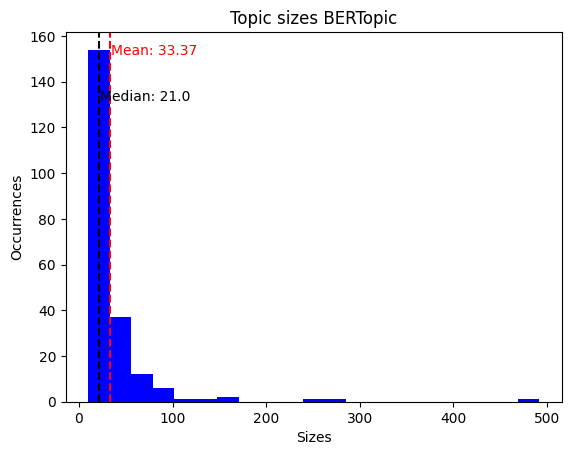

In [27]:
import matplotlib.pyplot as plt
import statistics as st

# How many topics did we get
topic_sizes = topic_model.topic_sizes_.values()
print("Number of topics:",len(topic_sizes)-1)

topic_sizes = topic_model.topic_sizes_
try:
    topic_sizes.pop(-1)
except: 
    pass

mean = round(st.mean(topic_sizes.values()),2)
median = round(st.median(topic_sizes.values()),2)

plt.hist(topic_sizes.values(), color='blue', bins=21) 

plt.axvline(x=mean, color='red', linestyle='--', label="Mean")
plt.axvline(x=median, color='black', linestyle='--', label="Median")
plt.text(mean+1, plt.ylim()[1]-10, f'Mean: {mean}', color='red')
plt.text(median+1, plt.ylim()[1]-30, f'Median: {median}', color='black')

plt.xlabel('Sizes')
plt.ylabel('Occurrences')
plt.title('Topic sizes BERTopic')
plt.show()

In [ ]:
# Visualize topics
topic_model.visualize_topics()